In this notebook, we are going to build a time series model to predict the future price of gold, which can be very useful for traders. For this purpose, we use the historical gold price data for 10 years (from 2013 to 2023).

lets get started:

## Step 1: Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM

## Step 2: Loading the dataset into a pandas data frame

In [2]:
df = pd.read_csv("Gold Price (2013-2023).csv")
df.head() # reading the first 5 rows from the data

,Date,Price,Open,High,Low,Vol.,Change %
0,12/30/2022,"1,826.20","1,821.80","1,832.40","1,819.80",107.50K,0.01%
1,12/29/2022,"1,826.00","1,812.30","1,827.30","1,811.20",105.99K,0.56%
2,12/28/2022,"1,815.80","1,822.40","1,822.80","1,804.20",118.08K,-0.40%
3,12/27/2022,"1,823.10","1,808.20","1,841.90","1,808.00",159.62K,0.74%
4,12/26/2022,"1,809.70","1,805.80","1,811.95","1,805.55",NaN,0.30%


## Step 3: Dataset Overview

In [4]:
print(df.columns.tolist())
print(f"The total number of the rows in the data is {df.shape[0]}")
print(f"The total number of the columns in the data is {df.shape[1]}")
print(f"The total number of the missing values in the data is {df.isnull().sum().sum()}")
print(f"The total number of the duplicated rows in the data is {df.duplicated().sum()}")

['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
The total number of the rows in the data is 2583
The total number of the columns in the data is 7
The total number of the missing values in the data is 5
The total number of the duplicated rows in the data is 0


As you can see, the data set includes daily gold price information including daily Open, High and Low prices and the final price of each day (Price) along with the volume of transactions and price changes in each day.

Dataset Basic Information:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2583 entries, 0 to 2582
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      2583 non-null   object
 1   Price     2583 non-null   object
 2   Open      2583 non-null   object
 3   High      2583 non-null   object
 4   Low       2583 non-null   object
 5   Vol.      2578 non-null   object
 6   Change %  2583 non-null   object
dtypes: object(7)
memory usage: 141.4+ KB


All variables are stored as object.

## Step 4: Data Preparation

### Step 4.1: Feature Subset Selection
Since we will not use Vol. and Change % features to predict Price, we will drop these two features:

In [7]:
df.drop(["Vol.", "Change %"], axis = 1, inplace=True) 

### Step 4.2: Transforming Data

Date feature is stored as object in the data frame. To increase the speed of calculations, we convert it's data type to datetime and then sort this feature in ascending order:

In [13]:
df["Date"] = pd.to_datetime(df["Date"]) 
df.sort_values(by ="Date", ascending=True, inplace=True) 
df.reset_index(drop=True, inplace=True)
df.head(10)


,Date,Price,Open,High,Low
0,2013-01-02,"1,689.90","1,675.80","1,695.00","1,672.10"
1,2013-01-03,"1,675.60","1,688.00","1,689.30","1,664.30"
2,2013-01-04,"1,649.90","1,664.40","1,664.40","1,630.00"
3,2013-01-07,"1,647.20","1,657.30","1,663.80","1,645.30"
4,2013-01-08,"1,663.20","1,651.50","1,662.60","1,648.80"
5,2013-01-09,"1,656.50","1,660.70","1,664.20","1,652.30"
6,2013-01-10,"1,679.00","1,656.70","1,679.20","1,656.70"
7,2013-01-11,"1,661.60","1,674.80","1,675.70","1,655.00"
8,2013-01-14,"1,670.40","1,662.30","1,675.20","1,662.30"
9,2013-01-15,"1,684.90","1,669.70","1,685.30","1,669.20"


In [14]:
df.dtypes

Date     datetime64[ns]
Price            object
Open             object
High             object
Low              object
dtype: object

The " , " sign is redundant in the dataset. First, we remove it from the entire dataset and then change the data type of the numerical variables to float:

In [17]:
NumColumns = df.columns.drop(["Date"]) 
print(NumColumns)
df[NumColumns] = df[NumColumns].replace({",":""}, regex = True)
df[NumColumns] = df[NumColumns].astype("float64") 

Index(['Price', 'Open', 'High', 'Low'], dtype='object')


In [18]:
df.dtypes

Date     datetime64[ns]
Price           float64
Open            float64
High            float64
Low             float64
dtype: object

In [19]:
df.head()

,Date,Price,Open,High,Low
0,2013-01-02,1689.9,1675.8,1695.0,1672.1
1,2013-01-03,1675.6,1688.0,1689.3,1664.3
2,2013-01-04,1649.9,1664.4,1664.4,1630.0
3,2013-01-07,1647.2,1657.3,1663.8,1645.3
4,2013-01-08,1663.2,1651.5,1662.6,1648.8


### Step 4.3: Checking Duplicates
There are no duplicate samples in Date feature:

In [22]:
print(f"The total number of the duplicated rows in the data is {df.duplicated().sum()}")

The total number of the duplicated rows in the data is 0


### Step 4.4: Checking Missing Values
There are no missing values in the dataset:

In [23]:
print(f"The total number of the missing values in the data is {df.isnull().sum().sum()}")

The total number of the missing values in the data is 0


## Step 5: Visualizing Gold Price History Data

Interactive Gold Price Chart:

In [29]:
df["Date"].head()

0   2013-01-02
1   2013-01-03
2   2013-01-04
3   2013-01-07
4   2013-01-08
Name: Date, dtype: datetime64[ns]

In [28]:
df["Date"].tail()

2578   2022-12-26
2579   2022-12-27
2580   2022-12-28
2581   2022-12-29
2582   2022-12-30
Name: Date, dtype: datetime64[ns]

In [26]:
fig = px.line(y=df["Price"], x=df["Date"])
fig.update_traces(line_color='black') 
fig.update_layout(xaxis_title="Date", 
                  yaxis_title="Scaled Price",
                  title={'text': "Gold Price History Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(255,223,0,0.8)')

d:\programs\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


## Step 6: Splitting Data to Training & Test Sets

Since we cannot train on future data in time series data, we should not divide the time series data randomly. In time series splitting, testing set is always later than training set. We consider the last year for testing and everything else for training:

### In time series data, the order of the data points matters because each data point depends on the previous ones.

For example, the value of sales in 2023 depends on the values in 2022 or earlier.

#### Explanation:
When you split data for training and testing in normal datasets (like random data), you might randomly pick some data points for training and others for testing. However, in time series, you can't do that because you can't "predict the past" using "future data."

So, we use earlier data for training and later data for testing.

#### Example:
Let’s say you have sales data from 2018 to 2023:2018-2019-2020-2021-2022-2023

If you split randomly, you might end up using 2023 data to train and 2020 data to test, which doesn't make sense in time series.

Instead, you should split like this:

- **Training data**: 2018, 2019, 2020, 2021, 2022
- **Testing data**: 2023

Here, you use the earlier years (2018-2022) to train the model and test it on the most recent year (2023), which makes sure you're predicting future values based on past data.


In [32]:
test_size = len(df[df["Date"].dt.year == 2022])
print(test_size)

260


Gold Price Training and Test Sets Plot:

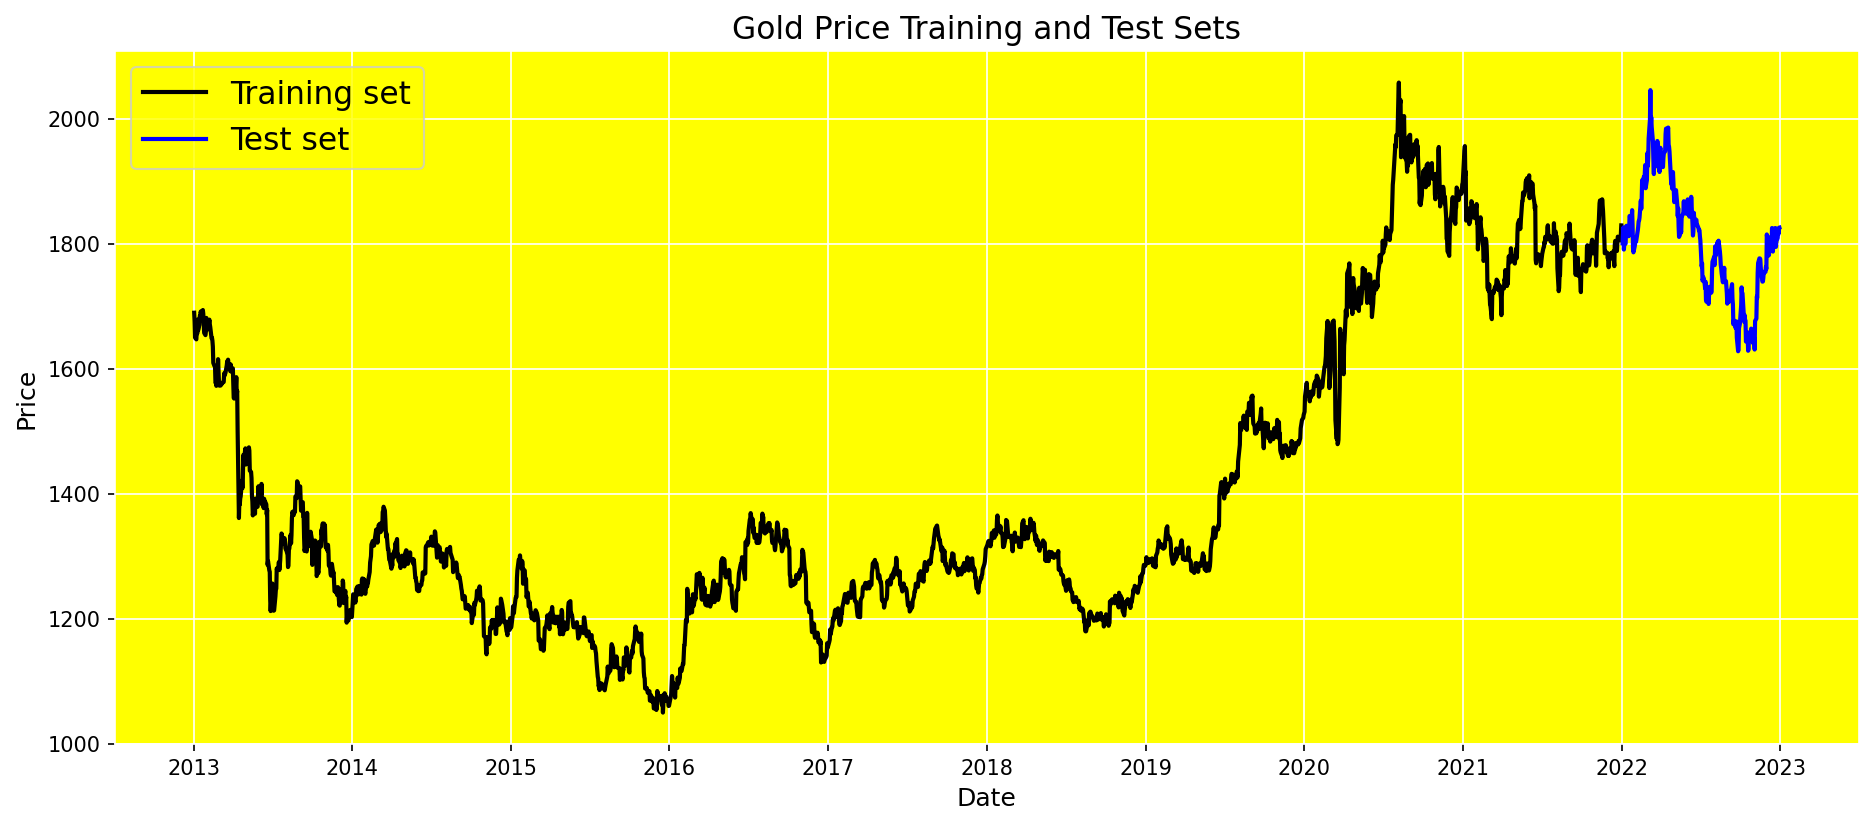

In [36]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df.Date[:-test_size], df.Price[:-test_size], color='black', lw=2) 
plt.plot(df.Date[-test_size:], df.Price[-test_size:], color='blue', lw=2) 
plt.title('Gold Price Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

## Step 7: Data Scaling
#### Since we aim to predict Price only based on its historical data, we scale Price using MinMaxScaler to avoid intensive computations:

In [39]:
print(type(df['Price']))
print(df["Price"].shape)

scaler = MinMaxScaler()
scaler.fit(df["Price"].values.reshape(-1,1))

<class 'pandas.core.series.Series'>
(2583,)


MinMaxScaler()

## Step 8: Restructure Data & Create Sliding Window

The use of prior time steps to predict the next time step is called **sliding window**. In this way, time series data can be expressed as supervised learning. We can do this by using previous time steps as input variables and use the next time step as the output variable. 

The number of previous time steps is called the **window width**. Here we set the window width to 60. Therefore, `X_train` and `X_test` will be nested lists containing lists of 60 time-stamp prices. `y_train` and `y_test` are also lists of gold prices containing the next day's gold price corresponding to each list in `X_train` and `X_test`, respectively.


### Simple Explanation:
In time series prediction, we use past values to predict the next value. This method is called the **sliding window** approach. It works by taking a fixed number of past values (called the **window width**) as input, and predicting the next value.

For example, if you're predicting daily gold prices, you could use the prices from the last 60 days (your window width) to predict the price on the next day.

- **X_train** and **X_test**: These contain lists of the past 60 days of gold prices (for training and testing).
- **y_train** and **y_test**: These contain the next day's gold price for each list in X_train and X_test.

So, the sliding window method allows you to use previous prices (like [1800, 1805, 1810]) to predict the next price (like 1815). In practice, you'd use a window width of 60 to capture more trends in the data.

In [40]:
window_size = 60

##### Training Set:

In [49]:
train_data = df.Price[:-test_size] 
train_data = scaler.transform(train_data.values.reshape(-1,1))
print(type(train_data))
print(train_data.ndim)
print(len(train_data))
print(train_data)

<class 'numpy.ndarray'>
2
2323
[[0.63471451]
 [0.62053925]
 [0.59506344]
 ...
 [0.74960349]
 [0.75902062]
 [0.773295  ]]


In [50]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

##### Test Set:

In [51]:
test_data = df.Price[-test_size-60:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [52]:
X_test = []
y_test = []
for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

### Step 9: Converting Data to Numpy Arrays

Now, `X_train` and `X_test` are nested lists (two-dimensional lists), and `y_train` is a one-dimensional list. We need to convert them to numpy arrays with a higher dimension, which is the data format accepted by TensorFlow when training the neural network.


In [53]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [54]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1)) 
y_test  = np.reshape(y_test, (-1,1)) 

## Step 10: Creating an LSTM Network
We build an LSTM network, which is a type of Recurrent Neural Networks designed to solve vanishing gradient problem:

Model Definition:

In [64]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64, return_sequences=True)(input1)  
    x = Dropout(0.2)(x)
    x = LSTM(units = 64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='linear')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    
    return model

#### Model Training:

In [65]:
model = define_model()
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.1, verbose=1)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 60, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,057 (332.25 KB)

 Trainable params: 85,057 (332.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - loss: 0.0274 - val_loss: 0.0020
Epoch 2/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 3/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 4/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 5/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.0017 - val_loss: 0.0037
Epoch 6/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 7/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 8/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 9/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 10/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 11/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0013 - val_loss: 9.9497e-04
Epoch 12/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms

## Step 11: Model Evaluation
Next, we evaluate our time series forecast using MAPE (Mean Absolute Percentage Error) metric:

In [66]:
result = model.evaluate(X_test, y_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.2452e-04


In [67]:
y_pred = model.predict(X_test) # hena ana 7a3ml predict l kol feauter vector mawgood gwa el X_test

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step


In [68]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE

In [69]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.0004558947402983904
Test MAPE: 0.0213753018759849
Test Accuracy: 0.9786246981240151


## Step 12: Visualizing Results
Returning the actual and predicted Price values to their primary scale:

In [70]:
y_test_true = scaler.inverse_transform(y_test) # ya3ny msh 7a5ly el arkam teb2a mawgooda mabeen el 0 and 1 w 7arg3ha tany zay ma kant
y_test_pred = scaler.inverse_transform(y_pred)

Investigating the closeness of the prices predicted by the model to the actual prices:

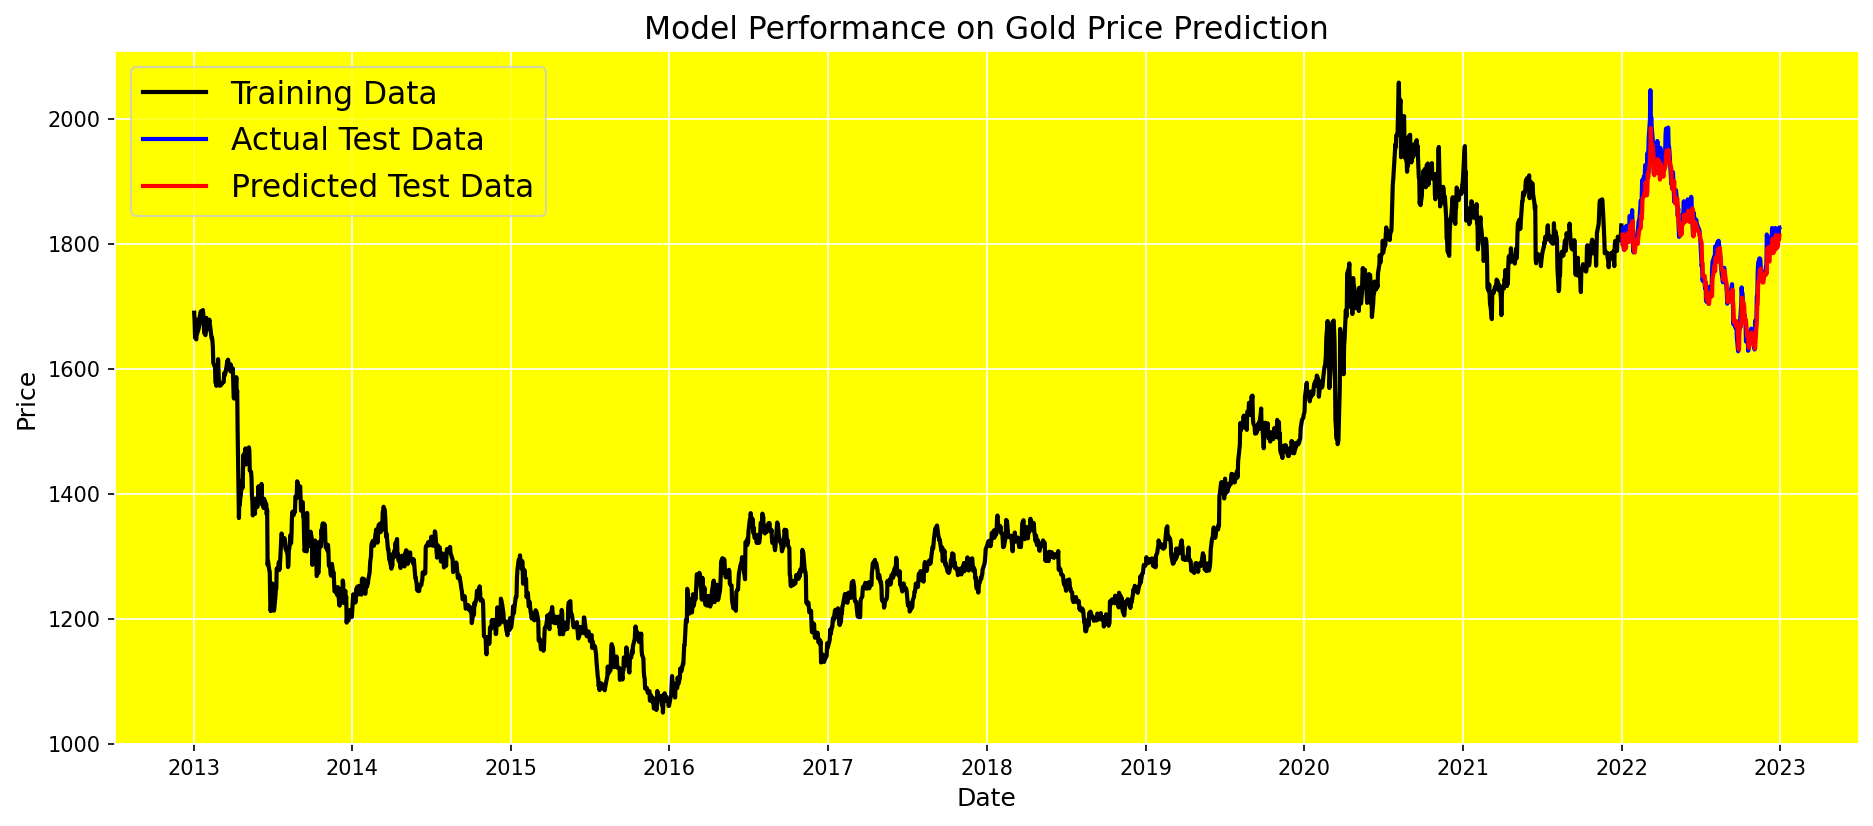

In [71]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()